In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function to compute MSE
def mse(y_hat, y_true):
    m = y_hat.shape[0]
    mserr = np.dot((y_hat - y_true).T, y_hat - y_true) / m
    return np.squeeze(mserr)

In [3]:
#function to generate polynomial features
def poly_featurizer(data, degree):
    
    from itertools import combinations_with_replacement 
    n_samples, n_features = data.shape
    
    def idx_comb():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(1, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = idx_comb()
    n_features = len(combinations)
    data_poly = np.empty((n_samples, n_features))
    
    for i, index_combs in enumerate(combinations):  
        data_poly[:, i] = np.prod(data[:, index_combs], axis=1)
    return data_poly

In [4]:
class RidgeRegression:
    
    def __init__(self, num_iterations=500, learning_rate=0.01, lambd=1.0):
        self.n_iter = num_iterations
        self.lr = learning_rate
        self.lambd = lambd
    
    
    def _init_params(self, n_features):
        '''
        This function creates a vector of zeros of shape (n_features, 1) for w and initializes b to 0
        '''
        self.w_ = np.zeros((n_features, 1))
        self.b_ = 0
    
    
    def _hypothesis(self, X, y):
        '''
        This function calculates cost
        X.shape: (n_samples, n_features)
        y.shape: (n_samples, 1)
        '''
        m = X.shape[0]
        y_hat = np.dot(X, self.w_) + self.b_
        return y_hat
    
    
    def fit(self, X_train, y_train):
        '''
        This function optimizes parameter vector w and bias b by running a gradient descent algorithm
        X_train.shape: (n_samples, n_features)
        y_train.shape: (n_samples, 1)
        '''
        n_samples, n_features = X_train.shape
        self._init_params(n_features)
        dw = np.zeros((n_features, 1))
        
        self.mse_ = []
        
        for i in range(self.n_iter):
            
            y_hat = self._hypothesis(X_train, y_train)
            
            dw *= 1 - self.lr * self.lambd / n_samples         #so-called 'weight decay'
            dw = np.dot(X_train.T, (y_hat - y_train)) / n_samples
            db = np.sum(y_hat - y_train) / n_samples  #usual derivative because we don`t regularize bias by convention
            
            self.w_ -= self.lr * dw
            self.b_ -= self.lr * db
            
            #write cost every 100 iterations
            if i % 1000 == 0:
                self.mse_.append(mse(y_hat, y_train))
    
    
    def predict(self, X_test):
        '''
        Make a prediction using learned parameters w and b
        '''
        y_hat = np.dot(X_test, self.w_) + self.b_
        return y_hat

In [5]:
#function to load data
def load_data():
    from sklearn.datasets import load_boston
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    boston = load_boston()
    data = boston.data[:, -1].reshape(-1, 1)
    target = boston.target[:, np.newaxis]
    
    #standardize the data
    sc = StandardScaler()
    data = sc.fit_transform(data)
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=17)
    return X_train, X_test, y_train, y_test, boston

In [6]:
#load data
X_train, X_test, y_train, y_test, plotting_set = load_data()

#explore the shapes obtained arrays
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (354, 1)
X_test.shape: (152, 1)
y_train.shape: (354, 1)
y_test.shape: (152, 1)


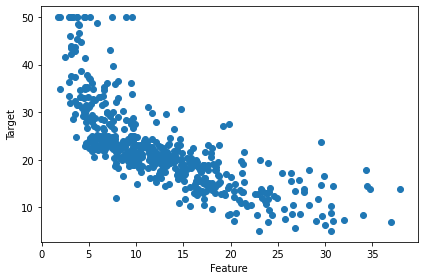

In [7]:
#visualize the dependency between feature and target
plt.figure(figsize=(6, 4))
plt.scatter(plotting_set.data[:, -1], plotting_set.target)
plt.ylabel('Target')
plt.xlabel('Feature')
plt.tight_layout()

In [8]:
#generate polynomial features up to degree=4
X_train_poly = poly_featurizer(X_train, degree=4)
X_test_poly = poly_featurizer(X_test, degree=4)

#explore the number of features attained
print(f'Now we have {X_train_poly.shape[1]} features in train/test sets')

Now we have 4 features in train/test sets


In [9]:
#train RidgeRegression with Polynomial Features
rdg = RidgeRegression(num_iterations=10000, learning_rate=0.001, lambd=0.05)
rdg.fit(X_train_poly, y_train)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


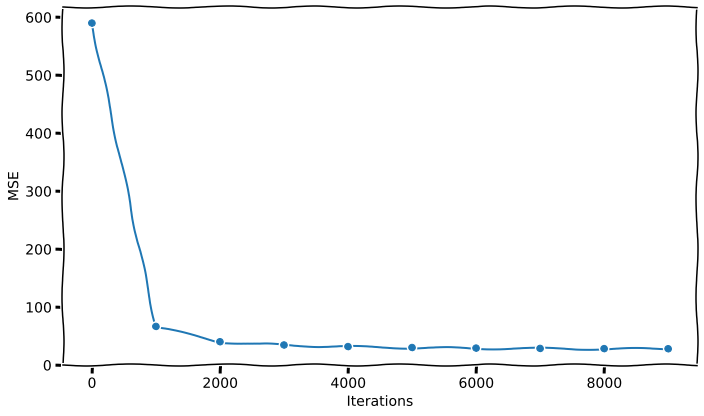

In [10]:
#plot MSE as a function of iterations
plt.figure(figsize=(10, 6))
with plt.xkcd():
    plt.plot(np.arange(0, 10000, 1000), rdg.mse_, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.tight_layout()

In [11]:
#print MSE on train/test sets
y_train_pred = rdg.predict(X_train_poly)
y_test_pred = rdg.predict(X_test_poly)

print(f'Train MSE: {mse(y_train_pred, y_train)}')
print(f'Test MSE: {mse(y_test_pred, y_test)}')

Train MSE: 27.320922511181895
Test MSE: 29.433946958150376


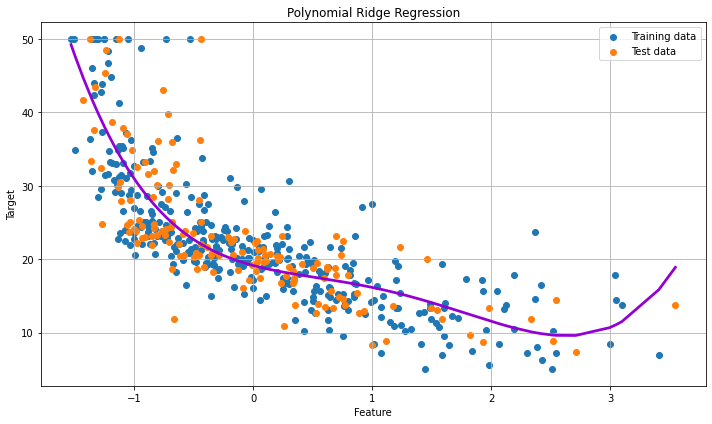

In [12]:
#plot learned curve
full_data = np.r_[X_train, X_test]
full_target_pred = np.r_[y_train_pred, y_test_pred]
idx = np.argsort(full_data, axis=0)
plt.figure(figsize=(10, 6))
plt.title('Polynomial Ridge Regression')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.scatter(X_train, y_train, label='Training data')
plt.scatter(X_test, y_test, label='Test data')
plt.plot(np.squeeze(full_data[idx]), np.squeeze(full_target_pred[idx]), c='darkviolet', linewidth=2.75)
plt.tight_layout()
plt.grid(True)
plt.legend(loc='best')